In [1]:
import numpy as np
from sklearn import preprocessing
import copy
import matplotlib.pyplot as plt

In [2]:
def activation(x): #sigmoid
    return 1/(1+np.exp(-x))

def dactivation(x): #sigmoid derivált
    return np.exp(-x)/((1+np.exp(-x))**2)

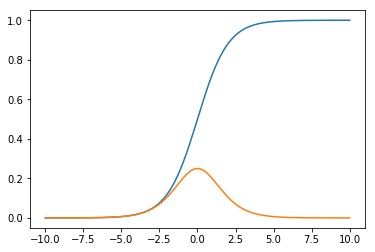

In [3]:
segedX = np.linspace(-10, 10, 200) #létrehoz 200 pontot -6 és 6 között
plt.plot(segedX, activation(segedX)) #x és y tengely
plt.plot(segedX, dactivation(segedX))

In [4]:
# nnetwork = MLP(2,3,1)
class MLP:
    def __init__(self, *args): #ctor self a this
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(self.shape[0]+1)) #bementi réteg shape[0] + bias
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size, self.layers[i+1].size))) #súlyok i. és i+1 réteg között
        #self.dw = .... #momentumhoz kell
        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size, self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1) #skálázás -1,1 -be

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data #az első réteg 0-utolsó előttiig (bias marad 1)
        for i in range(1,len(self.shape)):
            self.layers[i] = activation(np.dot(self.layers[i-1], self.weights[i-1]))

        return self.layers[-1] #utolsó layer

    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        error = -(target-self.layers[-1]) #cost fn alapján
        delta = np.multiply(error, dactivation(np.dot(self.layers[-2], self.weights[-1]))) #error * deriváltf(utolsó összeg) 
        deltas.append(delta)
                            
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * dactivation(np.dot(self.layers[i-1], self.weights[i-1]))
            deltas.insert(0, delta)
            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i]) #ha 1 dimenziós hozzáad egy tengelyt
            delta = np.atleast_2d(deltas[i])
                                
            dw = -lrate * np.dot(layer.T, delta) #momentum módszerhez ezt egészíteni
            self.weights[i] += dw
            
        # Visszatérés a hibával
        return (error ** 2).sum()

def learn(network, X, Y, valid_split, test_split, epochs=5000, lrate=0.01):
    min_val_err = np.inf
    best_modell = copy.copy(network)
    patience_counter = 0
    patience = 10
    
    # train-validation-test minták különválasztása
    X_train = X[0:int(X.shape[0]*(1-valid_split-test_split))]
    Y_train = Y[0:int(Y.shape[0]*(1-valid_split-test_split))]
    X_valid = X[int(X.shape[0]*(1-valid_split-test_split)) : int(X.shape[0]*(1-test_split))]
    Y_valid = Y[int(Y.shape[0]*(1-valid_split-test_split)) : int(Y.shape[0]*(1-test_split))]
    X_test  = X[int(X.shape[0]*(1-test_split)):]
    Y_test  = Y[int(Y.shape[0]*(1-test_split)):]
    
    # standardizálás
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test  = scaler.transform(X_test)
    
    # shuffle
    randperm = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[randperm], Y_train[randperm]

    # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
    for i in range(epochs):
        train_err = 0
        for k in range(X_train.shape[0]):
            network.propagate_forward( X_train[k])
            train_err += network.propagate_backward(Y_train[k], lrate)
            train_err /= X_train.shape[0]

        # validacio
        valid_err = 0
        o_valid = np.zeros(X_valid.shape[0])
        for k in range(X_valid.shape[0]):
            o_valid[k] = network.propagate_forward( X_valid[k] )
            valid_err += (o_valid[k] - Y_valid[k])**2
        valid_err /= Y_valid.shape[0]
        
        #early stopping
        if(valid_err<min_val_err):
            min_val_err = valid_err
            best_modell = copy.copy(network)
            patience_counter = 0
        else:
            patience_counter += 1 
        if(patience_counter > patience):
            network = best_modell
            print("Early stopping")
            break
        
        print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i,train_err,valid_err))
    # Tesztelési fázis
    test_err = 0
    o_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        o_test[k] = network.propagate_forward( X_test[k] )
        print("Predikcio:",o_test[k],"valos:",Y_test[k])
        test_err += (o_test[k] - Y_test[k])**2
    test_err /= Y_test.shape[0] 
        #fig1=plt.figure()
        #plt.scatter(...

In [5]:
network = MLP(2,2,1)

In [6]:
nb_samples = 200
X = np.zeros((nb_samples,2))
Y = np.zeros((nb_samples))
for i in range(0, nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i],   Y[i]   = (-2+noise[0], -2+noise[1]), 0
    X[i+1], Y[i+1] = ( 2+noise[2], -2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],  2+noise[5]), 1
    X[i+3], Y[i+3] = ( 2+noise[6],  2+noise[7]), 0

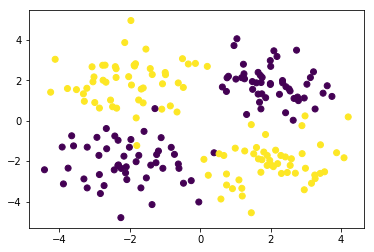

In [7]:
plt.scatter(X[:,0], X[:,1], c = Y[:])

In [10]:
network.reset()
learn(network,X,Y,0.2,0.01,lrate =0.1)

0 epoch, train_err: 0.0017, valid_err: 0.2511
1 epoch, train_err: 0.0017, valid_err: 0.2510
2 epoch, train_err: 0.0017, valid_err: 0.2510
3 epoch, train_err: 0.0017, valid_err: 0.2509
4 epoch, train_err: 0.0017, valid_err: 0.2509
5 epoch, train_err: 0.0017, valid_err: 0.2509
6 epoch, train_err: 0.0017, valid_err: 0.2508
7 epoch, train_err: 0.0017, valid_err: 0.2508
8 epoch, train_err: 0.0017, valid_err: 0.2507
9 epoch, train_err: 0.0017, valid_err: 0.2507
10 epoch, train_err: 0.0017, valid_err: 0.2506
11 epoch, train_err: 0.0017, valid_err: 0.2506
12 epoch, train_err: 0.0017, valid_err: 0.2505
13 epoch, train_err: 0.0017, valid_err: 0.2504
14 epoch, train_err: 0.0017, valid_err: 0.2503
15 epoch, train_err: 0.0017, valid_err: 0.2502
16 epoch, train_err: 0.0017, valid_err: 0.2501
17 epoch, train_err: 0.0017, valid_err: 0.2500
18 epoch, train_err: 0.0017, valid_err: 0.2498
19 epoch, train_err: 0.0017, valid_err: 0.2497
20 epoch, train_err: 0.0017, valid_err: 0.2495
21 epoch, train_err: 0.

176 epoch, train_err: 0.0000, valid_err: 0.1093
177 epoch, train_err: 0.0000, valid_err: 0.1092
178 epoch, train_err: 0.0000, valid_err: 0.1092
179 epoch, train_err: 0.0000, valid_err: 0.1092
180 epoch, train_err: 0.0000, valid_err: 0.1092
181 epoch, train_err: 0.0000, valid_err: 0.1091
182 epoch, train_err: 0.0000, valid_err: 0.1091
183 epoch, train_err: 0.0000, valid_err: 0.1091
184 epoch, train_err: 0.0000, valid_err: 0.1091
185 epoch, train_err: 0.0000, valid_err: 0.1090
186 epoch, train_err: 0.0000, valid_err: 0.1090
187 epoch, train_err: 0.0000, valid_err: 0.1090
188 epoch, train_err: 0.0000, valid_err: 0.1090
189 epoch, train_err: 0.0000, valid_err: 0.1089
190 epoch, train_err: 0.0000, valid_err: 0.1089
191 epoch, train_err: 0.0000, valid_err: 0.1089
192 epoch, train_err: 0.0000, valid_err: 0.1089
193 epoch, train_err: 0.0000, valid_err: 0.1089
194 epoch, train_err: 0.0000, valid_err: 0.1088
195 epoch, train_err: 0.0000, valid_err: 0.1088
196 epoch, train_err: 0.0000, valid_err:

347 epoch, train_err: 0.0000, valid_err: 0.1077
348 epoch, train_err: 0.0000, valid_err: 0.1077
349 epoch, train_err: 0.0000, valid_err: 0.1077
350 epoch, train_err: 0.0000, valid_err: 0.1077
351 epoch, train_err: 0.0000, valid_err: 0.1077
352 epoch, train_err: 0.0000, valid_err: 0.1077
353 epoch, train_err: 0.0000, valid_err: 0.1077
354 epoch, train_err: 0.0000, valid_err: 0.1077
355 epoch, train_err: 0.0000, valid_err: 0.1077
356 epoch, train_err: 0.0000, valid_err: 0.1077
357 epoch, train_err: 0.0000, valid_err: 0.1077
358 epoch, train_err: 0.0000, valid_err: 0.1077
359 epoch, train_err: 0.0000, valid_err: 0.1077
360 epoch, train_err: 0.0000, valid_err: 0.1077
361 epoch, train_err: 0.0000, valid_err: 0.1077
362 epoch, train_err: 0.0000, valid_err: 0.1077
363 epoch, train_err: 0.0000, valid_err: 0.1077
364 epoch, train_err: 0.0000, valid_err: 0.1077
365 epoch, train_err: 0.0000, valid_err: 0.1077
366 epoch, train_err: 0.0000, valid_err: 0.1077
367 epoch, train_err: 0.0000, valid_err:

526 epoch, train_err: 0.0000, valid_err: 0.1075
527 epoch, train_err: 0.0000, valid_err: 0.1075
528 epoch, train_err: 0.0000, valid_err: 0.1075
529 epoch, train_err: 0.0000, valid_err: 0.1075
530 epoch, train_err: 0.0000, valid_err: 0.1075
531 epoch, train_err: 0.0000, valid_err: 0.1075
532 epoch, train_err: 0.0000, valid_err: 0.1075
533 epoch, train_err: 0.0000, valid_err: 0.1075
534 epoch, train_err: 0.0000, valid_err: 0.1075
535 epoch, train_err: 0.0000, valid_err: 0.1075
536 epoch, train_err: 0.0000, valid_err: 0.1075
537 epoch, train_err: 0.0000, valid_err: 0.1075
538 epoch, train_err: 0.0000, valid_err: 0.1075
539 epoch, train_err: 0.0000, valid_err: 0.1075
540 epoch, train_err: 0.0000, valid_err: 0.1075
541 epoch, train_err: 0.0000, valid_err: 0.1075
542 epoch, train_err: 0.0000, valid_err: 0.1075
543 epoch, train_err: 0.0000, valid_err: 0.1075
544 epoch, train_err: 0.0000, valid_err: 0.1075
545 epoch, train_err: 0.0000, valid_err: 0.1075
546 epoch, train_err: 0.0000, valid_err:

699 epoch, train_err: 0.0000, valid_err: 0.1074
700 epoch, train_err: 0.0000, valid_err: 0.1074
701 epoch, train_err: 0.0000, valid_err: 0.1074
702 epoch, train_err: 0.0000, valid_err: 0.1074
703 epoch, train_err: 0.0000, valid_err: 0.1074
704 epoch, train_err: 0.0000, valid_err: 0.1074
705 epoch, train_err: 0.0000, valid_err: 0.1074
706 epoch, train_err: 0.0000, valid_err: 0.1074
707 epoch, train_err: 0.0000, valid_err: 0.1074
708 epoch, train_err: 0.0000, valid_err: 0.1074
709 epoch, train_err: 0.0000, valid_err: 0.1074
710 epoch, train_err: 0.0000, valid_err: 0.1074
711 epoch, train_err: 0.0000, valid_err: 0.1074
712 epoch, train_err: 0.0000, valid_err: 0.1074
713 epoch, train_err: 0.0000, valid_err: 0.1074
714 epoch, train_err: 0.0000, valid_err: 0.1074
715 epoch, train_err: 0.0000, valid_err: 0.1074
716 epoch, train_err: 0.0000, valid_err: 0.1074
717 epoch, train_err: 0.0000, valid_err: 0.1074
718 epoch, train_err: 0.0000, valid_err: 0.1074
719 epoch, train_err: 0.0000, valid_err: